In [118]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0,ResNet50

from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

# 1. Data Cleaning & Processing

In [2]:
dir="./dataset"
fold_labels=os.listdir(dir)

In [3]:
fold_labels

['.ipynb_checkpoints',
 'dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

## Data Combining

In [111]:
images_path=[]
flattened_images=[]
labels=[]
for i in fold_labels:
    fold_path=dir+"//"+i
    img_labels=os.listdir(fold_path)
    for j in img_labels:
        img_path=fold_path+"//"+j
        img = Image.open(img_path)
        img_gray = img.convert('L')
        img_resized = img_gray.resize((28, 28))
        img_array = np.array(img_resized)
        flattened_img = img_array.flatten()
        #print(flattened_img.shape)
        flattened_images.append(flattened_img)
        labels.append(i)
        images_path.append(img_path)

In [7]:
for i in fold_labels:
    print(i,":",len(os.listdir(dir+"//"+i)))

.ipynb_checkpoints : 0
dew : 698
fogsmog : 851
frost : 475
glaze : 639
hail : 591
lightning : 377
rain : 526
rainbow : 232
rime : 1160
sandstorm : 692
snow : 621


In [8]:
df_flt_images=pd.DataFrame(flattened_images)
df_labels=pd.DataFrame(labels,columns=["label"])
df_images_path=pd.DataFrame(images_path,columns=['image'])

In [9]:
df_flt_img_lbl=pd.concat([df_flt_images,df_labels],axis=1)

In [10]:
df_flt_img_lbl

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,93,92,92,91,90,90,89,89,88,88,...,44,26,14,9,13,30,50,59,76,dew
1,51,49,45,74,87,66,44,44,57,62,...,108,110,108,120,127,104,105,106,106,dew
2,96,72,88,169,112,120,92,106,97,103,...,73,7,0,0,0,0,0,0,0,dew
3,12,17,23,27,31,34,37,44,74,115,...,53,51,44,37,32,30,29,29,30,dew
4,221,223,231,238,235,229,224,214,230,233,...,145,153,167,183,182,188,161,199,203,dew
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6857,122,134,158,167,160,166,151,166,216,249,...,255,252,152,86,82,72,86,96,112,snow
6858,36,36,36,37,37,37,48,47,38,40,...,63,69,103,95,22,16,21,27,28,snow
6859,155,160,162,178,227,255,252,247,241,236,...,126,125,61,153,94,106,124,90,62,snow
6860,12,14,31,57,60,121,171,177,201,177,...,153,146,137,123,129,159,116,92,93,snow


In [11]:
df_img_path_lbl=pd.concat([df_images_path,df_labels],axis=1)

In [12]:
df_img_path_lbl

,image,label
0,./dataset//dew//2208.jpg,dew
1,./dataset//dew//2209.jpg,dew
2,./dataset//dew//2210.jpg,dew
3,./dataset//dew//2211.jpg,dew
4,./dataset//dew//2212.jpg,dew
...,...,...
6857,./dataset//snow//1446.jpg,snow
6858,./dataset//snow//1447.jpg,snow
6859,./dataset//snow//1448.jpg,snow
6860,./dataset//snow//1449.jpg,snow


# 2. Data visualization

In [13]:
classes=df_flt_img_lbl['label'].unique()
classes

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

In [14]:
df_flt_img_lbl['label'].value_counts()

label
rime         1160
fogsmog       851
dew           698
sandstorm     692
glaze         639
snow          621
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: count, dtype: int64

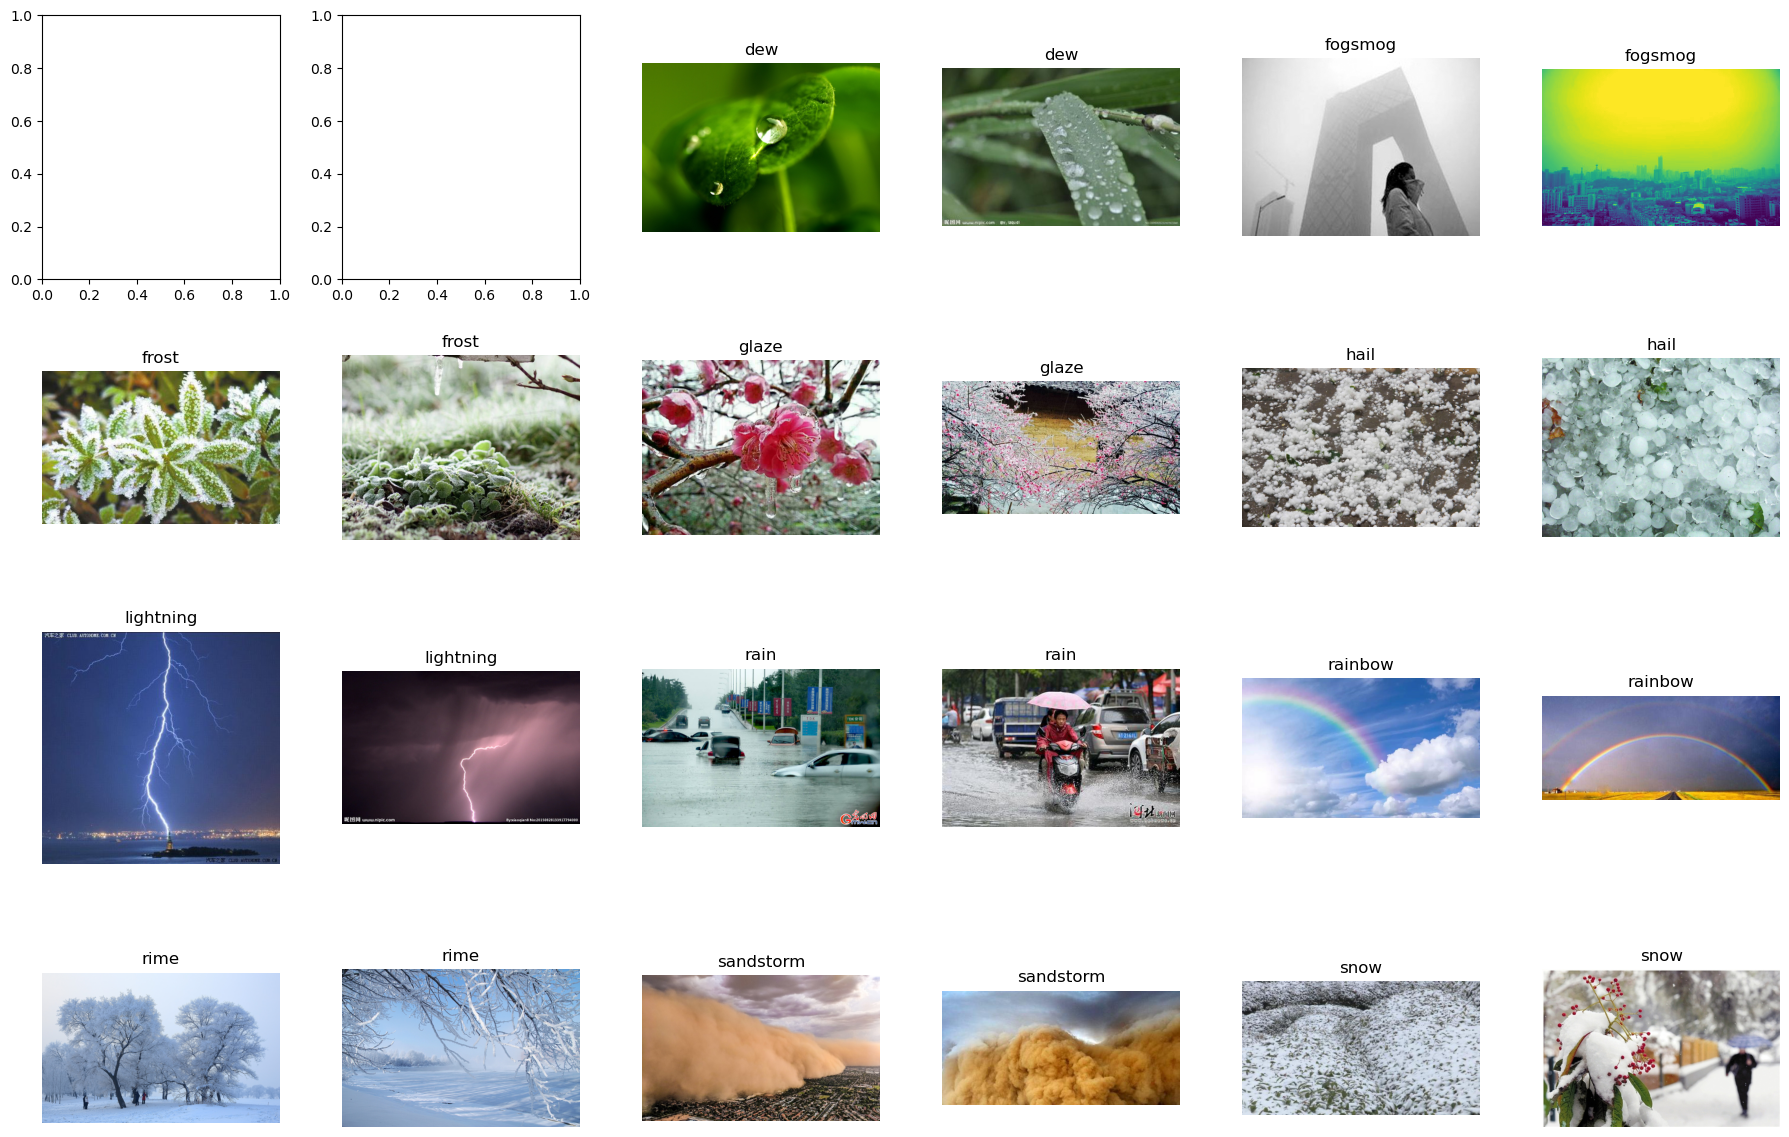

In [15]:

def plot_images_from_directory(directory):
    # Get list of folders (class labels)
    classes = os.listdir(directory)
    
    # Calculate number of rows and columns needed based on the number of classes
    num_classes = len(classes)
    rows = (num_classes + 2) // 3  # Number of rows needed for 3 classes per row
    cols = 6  # 2 images per class
    
    # Create a grid for plotting images
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    # Plot images from each folder
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        image_files = os.listdir(class_dir)
        
        # Plot up to 2 images for each class
        for j, image_file in enumerate(image_files[:2]):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)
            
            row_index = i // 3  # Calculate row index for the class
            col_index = (i % 3) * 2 + j  # Calculate column index for the image
            ax = axes[row_index, col_index]  # Calculate subplot index
            ax.imshow(img)
            ax.set_title(class_name)  # Use folder name as label
            ax.axis('off')
    
    # Remove empty subplots
    for i in range(num_classes, rows * 3):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show()

# Example usage:
directory = "./dataset"
plot_images_from_directory(directory)

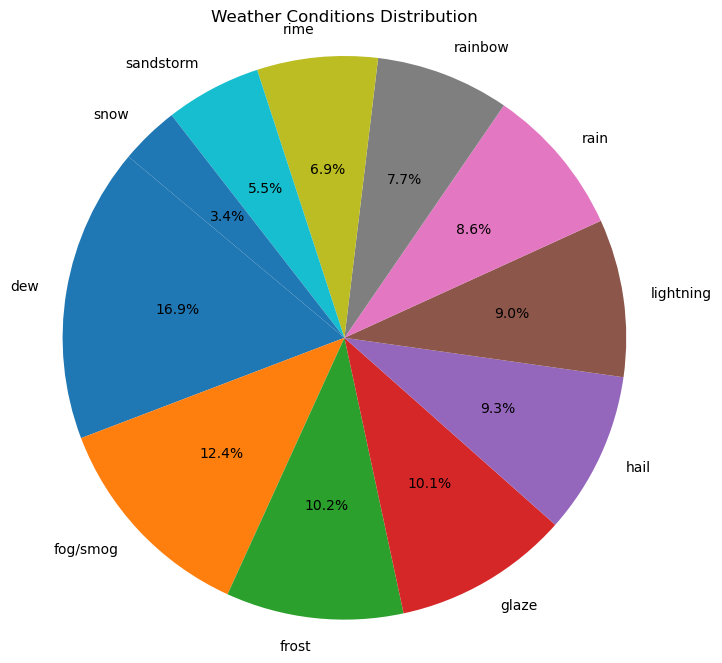

In [70]:
weather_conditions = ['dew', 'fog/smog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
occurrences = df_flt_img_lbl['label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(occurrences, labels=weather_conditions, autopct='%1.1f%%', startangle=140)
plt.title('Weather Conditions Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

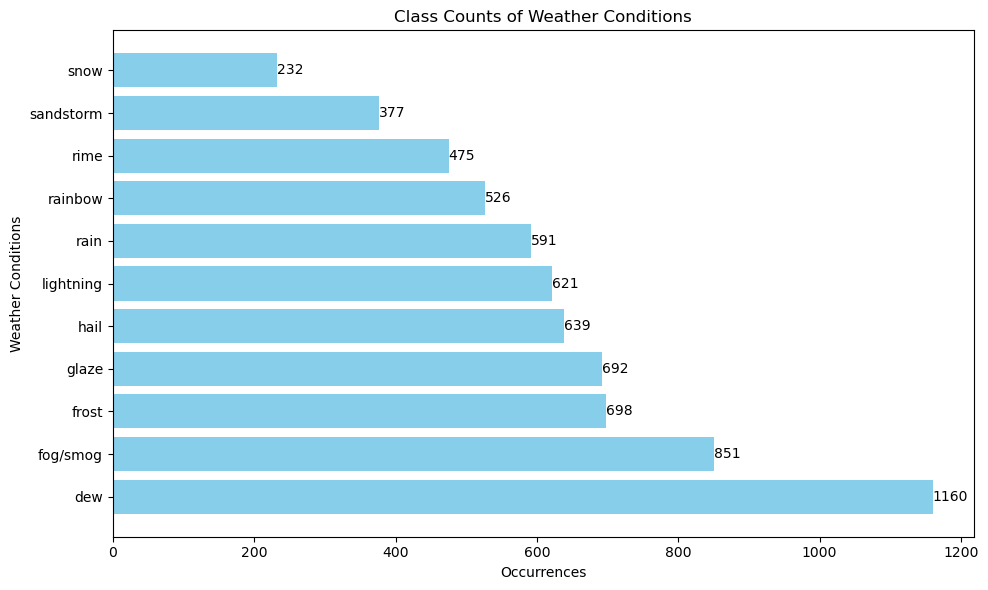

In [72]:
weather_conditions = ['dew', 'fog/smog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
occurrences = df_flt_img_lbl['label'].value_counts()

# Plotting the horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(weather_conditions, occurrences, color='skyblue')  # Use plt.barh() for horizontal bars
plt.xlabel('Occurrences')
plt.ylabel('Weather Conditions')
plt.title('Class Counts of Weather Conditions')

# Annotating each bar with its count
for bar, count in zip(bars, occurrences):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(count), ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Model Preprocessing

In [19]:
X=df_flt_img_lbl.iloc[:,:-1]
X

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,93,92,92,91,90,90,89,89,88,88,...,66,44,26,14,9,13,30,50,59,76
1,51,49,45,74,87,66,44,44,57,62,...,122,108,110,108,120,127,104,105,106,106
2,96,72,88,169,112,120,92,106,97,103,...,49,73,7,0,0,0,0,0,0,0
3,12,17,23,27,31,34,37,44,74,115,...,102,53,51,44,37,32,30,29,29,30
4,221,223,231,238,235,229,224,214,230,233,...,149,145,153,167,183,182,188,161,199,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6857,122,134,158,167,160,166,151,166,216,249,...,255,255,252,152,86,82,72,86,96,112
6858,36,36,36,37,37,37,48,47,38,40,...,81,63,69,103,95,22,16,21,27,28
6859,155,160,162,178,227,255,252,247,241,236,...,119,126,125,61,153,94,106,124,90,62
6860,12,14,31,57,60,121,171,177,201,177,...,112,153,146,137,123,129,159,116,92,93


In [20]:
y=df_flt_img_lbl.iloc[:,-1:]
y

,label
0,dew
1,dew
2,dew
3,dew
4,dew
...,...
6857,snow
6858,snow
6859,snow
6860,snow


In [21]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=384)

In [22]:
sc=StandardScaler()
pca=PCA()

pp=make_pipeline(StandardScaler(),PCA(n_components=100))

In [23]:
X_train_pp=pp.fit_transform(X_train)
X_test_pp=pp.fit_transform(X_test)

## b. Initial Supervised Models

### Logistic Regression

In [24]:


lgr = LogisticRegression()
lgr_model_b = lgr.fit(X_train,y_train)


### Decision Tree Classifier

In [25]:


dt = DecisionTreeClassifier()
dt_model_b = dt.fit(X_train,y_train)


### Random Forest Classifier

In [26]:


rf = RandomForestClassifier()
rf_model_b = rf.fit(X_train,y_train)


### Support Vector Machine

In [28]:

svm = SVC()
svm_model_b = svm.fit(X_train,y_train)


## C. Supervised Models with PCA

### Logistic regression

In [29]:


lgr = LogisticRegression()
lgr_model_c = lgr.fit(X_train_pp,y_train)


### Decision Tree Classifier

In [30]:


dt = DecisionTreeClassifier()
dt_model_c = dt.fit(X_train_pp,y_train)


### Random Forest Classifier

In [31]:


rf = RandomForestClassifier()
rf_model_c = rf.fit(X_train_pp,y_train)


### Support Vector Machine

In [33]:

svm = SVC()
svm_model_c = svm.fit(X_train_pp,y_train)


## d. Neural Networks

## Image Generator for Neural Networks

In [34]:

images = []
labels = []

folder_path='./dataset'
for class_label in os.listdir(folder_path):
    class_folder = os.path.join(folder_path, class_label)
        
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
                
            if img is not None:
                img = cv2.resize(img, (224, 224))  
                img = img.astype('float32') / 255.0 
                images.append(img)
                labels.append(class_label)

images = np.array(images)
labels = np.array(labels)

In [35]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(labels_encoded)

In [36]:
X_Train, X_Test, y_Train, y_Test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

In [37]:
X_validation, X_final_test, y_validation, y_final_test = train_test_split(X_Test, y_Test, test_size=0.5, shuffle=True, random_state=42)

### CNN

In [128]:
cnn_model_d=Sequential([
Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
    
Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),

Flatten(),
Dense(64,activation='relu'),
Dense(11,activation='softmax')
])

In [129]:

cnn_model_d.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [130]:
cnn_model_history=cnn_model_d.fit(X_Train, y_Train, epochs=10, batch_size=64, validation_data=(X_validation, y_validation))

Epoch 1/10
86/86 [==============================] - 84s 924ms/step - loss: 1.6220 - accuracy: 0.4772 - val_loss: 1.2573 - val_accuracy: 0.5991
Epoch 2/10
86/86 [==============================] - 79s 920ms/step - loss: 0.9643 - accuracy: 0.6855 - val_loss: 1.0551 - val_accuracy: 0.6429
Epoch 3/10
86/86 [==============================] - 78s 913ms/step - loss: 0.7235 - accuracy: 0.7662 - val_loss: 1.1248 - val_accuracy: 0.6297
Epoch 4/10
86/86 [==============================] - 78s 905ms/step - loss: 0.4572 - accuracy: 0.8601 - val_loss: 0.9959 - val_accuracy: 0.6895
Epoch 5/10
86/86 [==============================] - 76s 889ms/step - loss: 0.2749 - accuracy: 0.9196 - val_loss: 0.9955 - val_accuracy: 0.6997
Epoch 6/10
86/86 [==============================] - 78s 913ms/step - loss: 0.1794 - accuracy: 0.9528 - val_loss: 1.2843 - val_accuracy: 0.6939
Epoch 7/10
86/86 [==============================] - 78s 902ms/step - loss: 0.1181 - accuracy: 0.9661 - val_loss: 1.2550 - val_accuracy: 0.6895

In [131]:
cnn_model_d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 93312)             0         
                                                                 
 dense_6 (Dense)             (None, 64)               

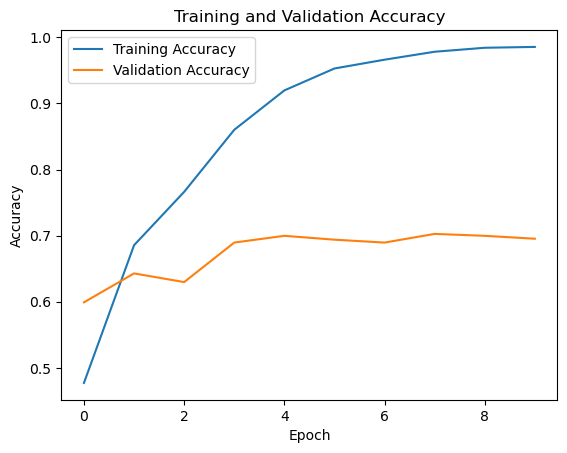

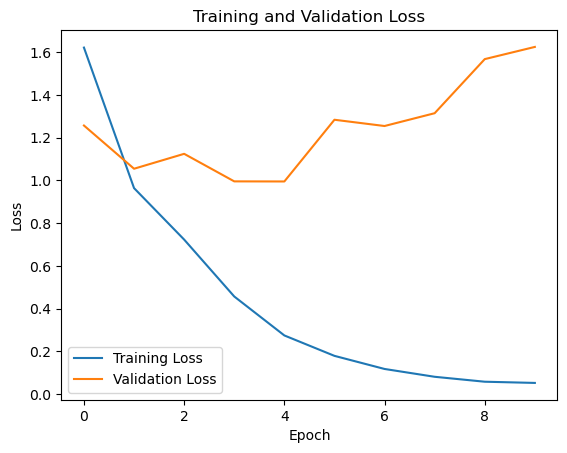

In [132]:
plt.plot(cnn_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    # Plot training loss
plt.plot(cnn_model_history.history['loss'], label='Training Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
cnn_model_d.save('./models/cnn_model_d')
cnn_model_d.save_weights('./models/cnn_model_d_weights.h5')

INFO:tensorflow:Assets written to: ./models/cnn_model_d\assets


INFO:tensorflow:Assets written to: ./models/cnn_model_d\assets


### ResNet

In [85]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [86]:
for layer in base_model.layers:
    layer.trainable = False

In [87]:
resnet_model_d = Sequential([
base_model,
GlobalAveragePooling2D(),
Dense(64, activation='relu'),
Dense(11, activation='softmax')]
)

In [88]:
resnet_model_d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [89]:
resnet_model_history=resnet_model_d.fit(X_Train, y_Train, epochs=10, batch_size=64, validation_data=(X_validation, y_validation))

Epoch 1/10
86/86 [==============================] - 1131s 13s/step - loss: 2.1741 - accuracy: 0.2165 - val_loss: 2.0885 - val_accuracy: 0.2289
Epoch 2/10
86/86 [==============================] - 425s 5s/step - loss: 1.9814 - accuracy: 0.2768 - val_loss: 2.0198 - val_accuracy: 0.2741
Epoch 3/10
86/86 [==============================] - 415s 5s/step - loss: 1.9056 - accuracy: 0.2957 - val_loss: 1.9576 - val_accuracy: 0.2726
Epoch 4/10
86/86 [==============================] - 445s 5s/step - loss: 1.8433 - accuracy: 0.3284 - val_loss: 1.8920 - val_accuracy: 0.3105
Epoch 5/10
86/86 [==============================] - 446s 5s/step - loss: 1.8042 - accuracy: 0.3369 - val_loss: 1.8601 - val_accuracy: 0.2974
Epoch 6/10
86/86 [==============================] - 437s 5s/step - loss: 1.7668 - accuracy: 0.3537 - val_loss: 1.8367 - val_accuracy: 0.3717
Epoch 7/10
86/86 [==============================] - 3123s 37s/step - loss: 1.7374 - accuracy: 0.3673 - val_loss: 1.8097 - val_accuracy: 0.3324
Epoch 8/1

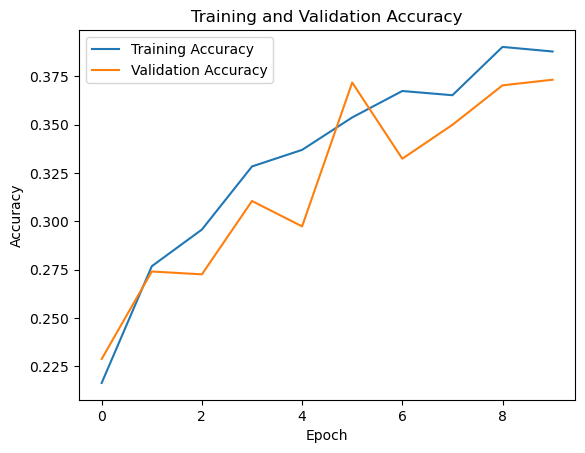

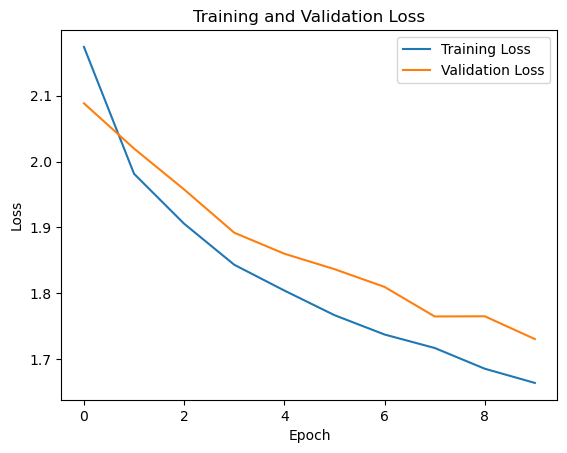

In [90]:
plt.plot(resnet_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    # Plot training loss
plt.plot(resnet_model_history.history['loss'], label='Training Loss')
plt.plot(resnet_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [192]:
resnet_model_d.save('./models/resnet_model_d')
resnet_model_d.save_weights('./models/resnet_model_d_weights.h5')

INFO:tensorflow:Assets written to: ./models/effnet_model_d\assets


INFO:tensorflow:Assets written to: ./models/effnet_model_d\assets


### EfficientNet with Tuning

In [93]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')

effnet_model_d = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(11, activation= 'softmax')
])


In [94]:
effnet_model_d.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [95]:
effnet_model_d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 11)                2827      
                                                                 
Total params: 11185978 (42.67 MB)
Trainable params: 11

In [116]:
# This particular part is crashing while running, although when we ran for the first time it went well and below accuraciesin the charts were recorded
#effnet_model_history=effnet_model_d.fit(X_Train, y_Train, epochs=10, batch_size=64, validation_data=(X_validation, y_validation))

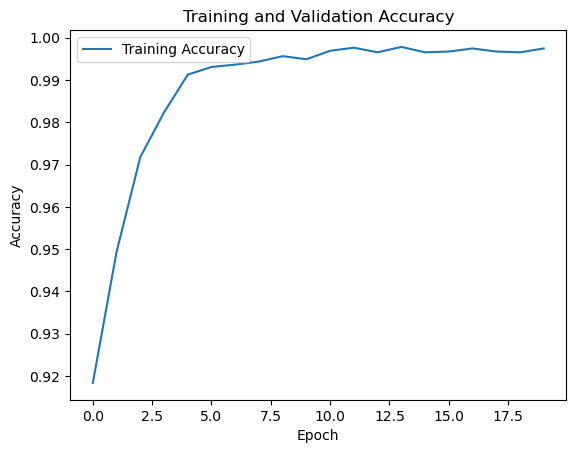

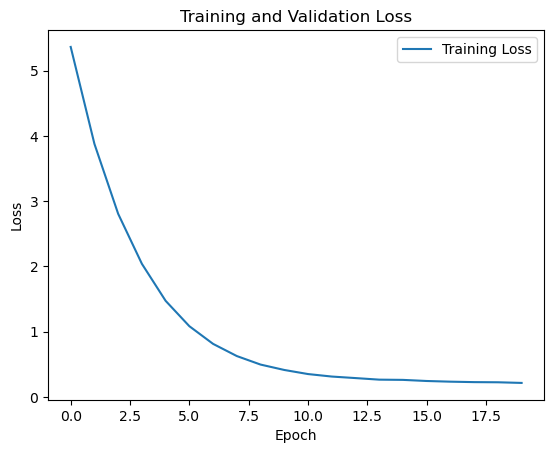

In [191]:
plt.plot(effnet_history.history['accuracy'], label='Training Accuracy')
#plt.plot(effnet_hyp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

    # Plot training loss
plt.plot(effnet_history.history['loss'], label='Training Loss')
#plt.plot(effnet_hyp_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [193]:
effnet_model_d.save('./models/effnet_model_d')
effnet_model_d.save_weights('./models/effnet_model_d_weights.h5')

INFO:tensorflow:Assets written to: ./models/effnet_hyp_model_d\assets


INFO:tensorflow:Assets written to: ./models/effnet_hyp_model_d\assets


## 4. Model Evaluation

In [82]:
def model_evaluator(y_test,y_pred,classes):
    cm = metrics.confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(100,10))

    # Create a ConfusionMatrixDisplay object
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)



    # Customize the appearance of the confusion matrix
    disp.plot(cmap='Blues', values_format='d')

    # Add a title
    plt.title('Confusion Matrix')

    # Add axis labels
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.xticks(rotation=90)

    # Show the confusion matrix
    plt.show()
    acc=round(metrics.accuracy_score(y_test,y_pred)*100,2)
    print("Model Accuracy:",acc,"%")

## b. Initial Supervised Models

### Logistic regression

In [43]:
lgr.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

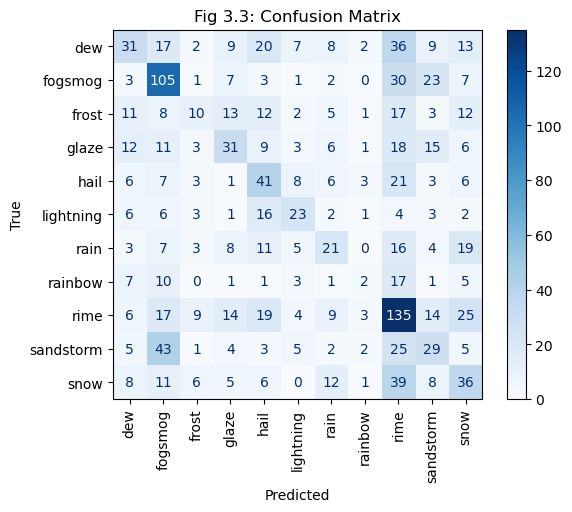

Model Accuracy: 33.79 %


In [44]:
model_evaluator(y_test,lgr_model_b.predict(X_test),lgr.classes_)

### Decision Tree Classifier

In [45]:
dt.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

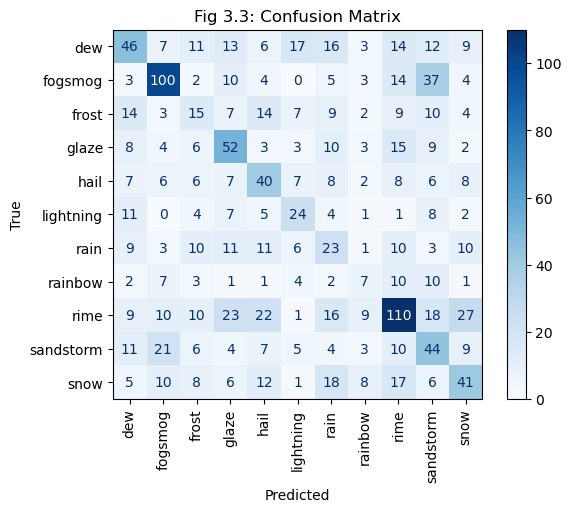

Model Accuracy: 36.56 %


In [46]:
model_evaluator(y_test,dt_model_b.predict(X_test),dt.classes_)

### Random Forest Classifier

In [47]:
rf.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

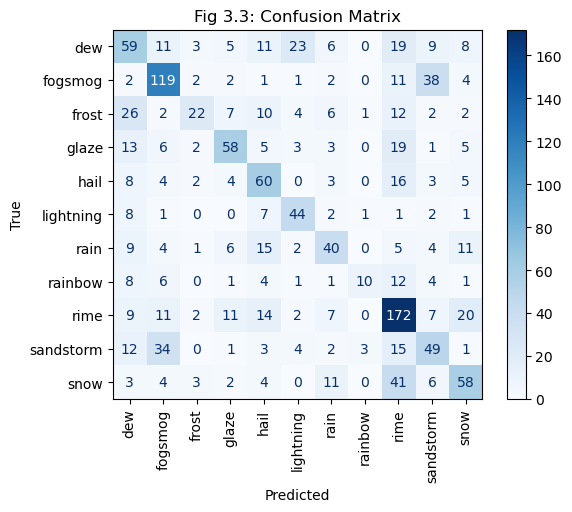

Model Accuracy: 50.33 %


In [48]:
model_evaluator(y_test,rf_model_b.predict(X_test),rf.classes_)

###  SVM

In [51]:
svm.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

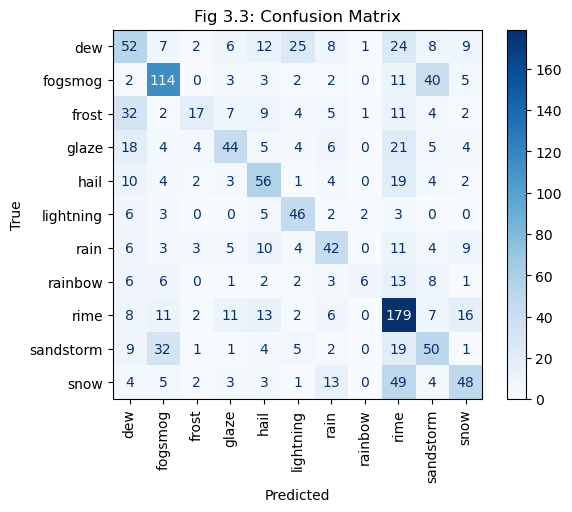

Model Accuracy: 47.63 %


In [52]:
model_evaluator(y_test,svm_model_b.predict(X_test),svm.classes_)

## c. Supervised Models with PCA

### Logistic regression

In [55]:
lgr.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

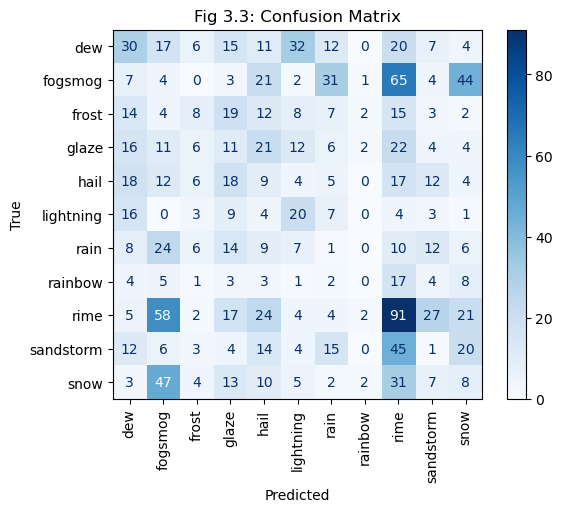

Model Accuracy: 13.33 %


In [56]:
model_evaluator(y_test,lgr_model_c.predict(X_test_pp),lgr.classes_)

### Decision Tree Classifier

In [57]:
dt.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

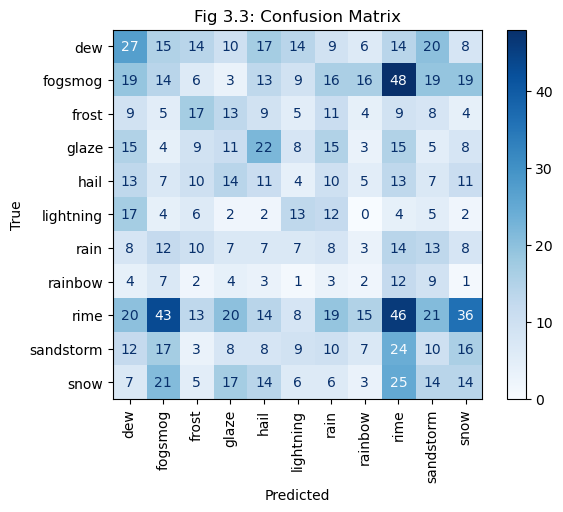

Model Accuracy: 12.6 %


In [58]:
model_evaluator(y_test,dt_model_c.predict(X_test_pp),dt.classes_)

### Random Forest Classifier

In [59]:
rf.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

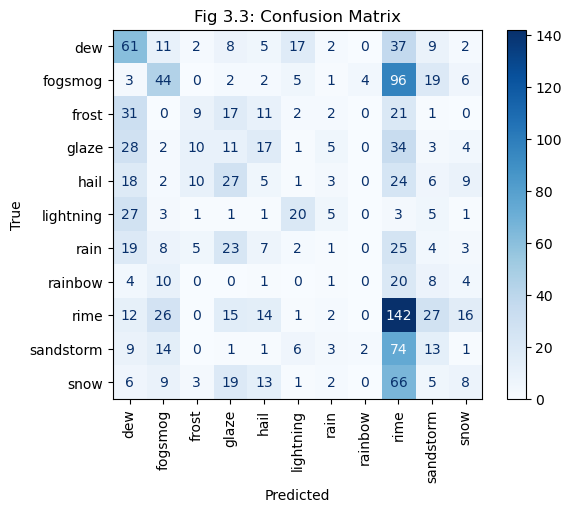

Model Accuracy: 22.87 %


In [60]:
model_evaluator(y_test,rf_model_c.predict(X_test_pp),rf.classes_)

###  SVM

In [63]:
svm.classes_

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

<Figure size 10000x1000 with 0 Axes>

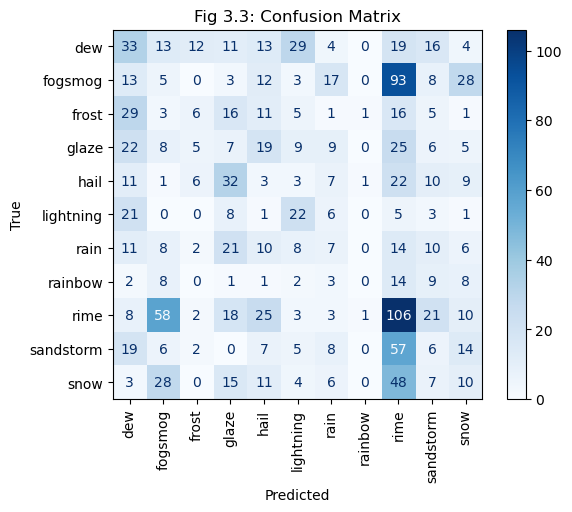

Model Accuracy: 14.93 %


In [64]:
model_evaluator(y_test,svm_model_c.predict(X_test_pp),svm.classes_)

## d. Neural Networks

### CNN

In [123]:
from sklearn.metrics import classification_report

# Assuming cnn_model_d.predict(X_final_test) returns the predicted probabilities
y_pred = np.argmax(cnn_model_d.predict(X_final_test), axis=1)

# Assuming y_final_test contains the ground truth labels
y_true = np.argmax(y_final_test, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred)

# Print classification report
print(f"Classification Report for CNN:")
print(report)

22/22 [==============================] - 3s 116ms/step
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.48      0.43      0.46        74
           1       0.48      0.45      0.46        92
           2       0.31      0.40      0.35        45
           3       0.44      0.42      0.43        64
           4       0.30      0.37      0.33        51
           5       0.38      0.15      0.21        40
           6       0.33      0.30      0.31        54
           7       0.10      0.10      0.10        20
           8       0.32      0.38      0.35       109
           9       0.45      0.42      0.43        78
          10       0.27      0.29      0.28        59

    accuracy                           0.37       686
   macro avg       0.35      0.34      0.34       686
weighted avg       0.37      0.37      0.37       686



22/22 [==============================] - 8s 280ms/step


<Figure size 10000x1000 with 0 Axes>

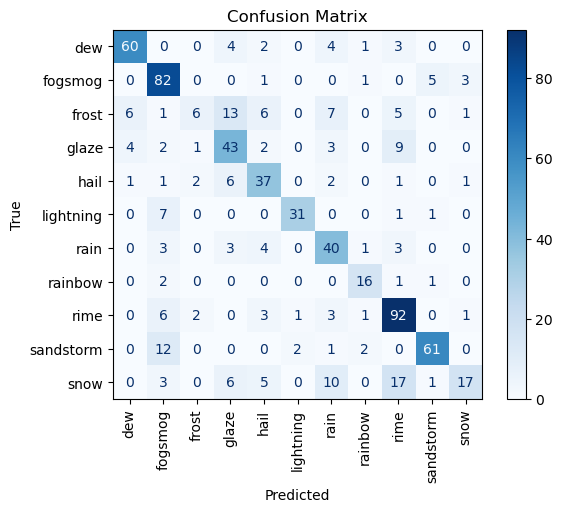

Model Accuracy: 70.7 %


In [83]:
model_evaluator(np.argmax(y_final_test,axis=1),np.argmax(cnn_model_d.predict(X_final_test),axis=1),label_encoder.classes_)

## ResNet

43/43 [==============================] - 324s 7s/step


<Figure size 10000x1000 with 0 Axes>

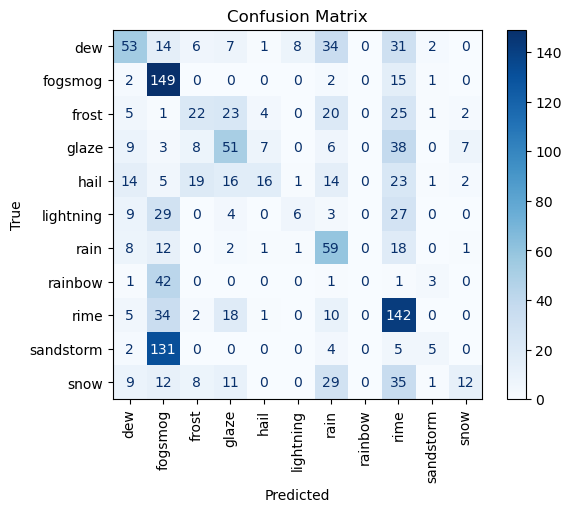

Model Accuracy: 37.54 %


In [92]:
model_evaluator(np.argmax(y_Test,axis=1),np.argmax(resnet_model_d.predict(X_Test),axis=1),label_encoder.classes_)

# Efficient Net

43/43 [==============================] - 166s 4s/step


<Figure size 10000x1000 with 0 Axes>

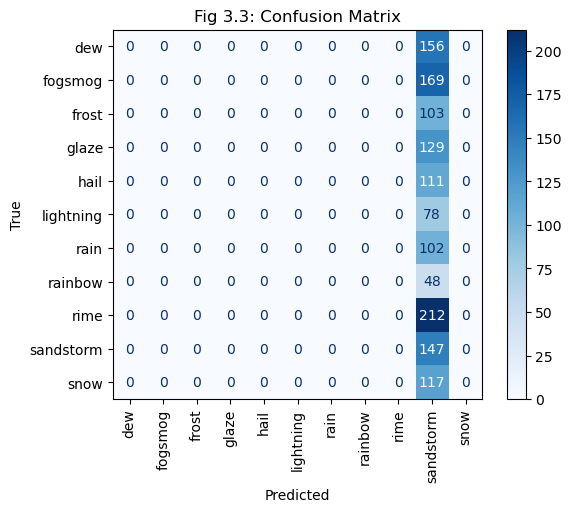

Model Accuracy: 10.71 %


In [195]:
model_evaluator(np.argmax(y_Test,axis=1),np.argmax(effnet_model_d.predict(X_Test),axis=1),label_encoder.classes_)

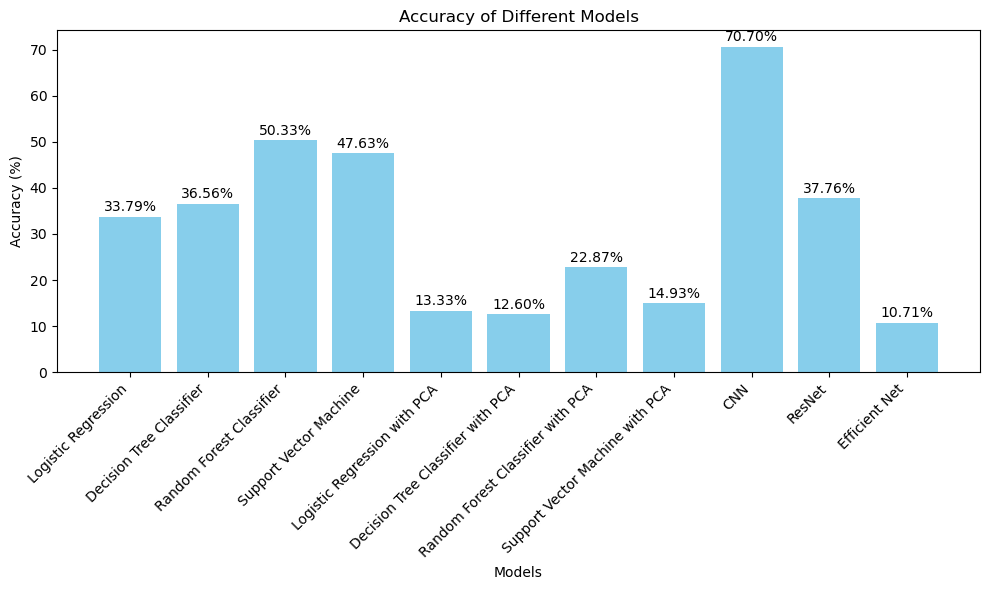

In [117]:
models = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "Support Vector Machine",
    "Logistic Regression with PCA",
    "Decision Tree Classifier with PCA",
    "Random Forest Classifier with PCA",
    "Support Vector Machine with PCA",
    "CNN",
    "ResNet",
    "Efficient Net"
]

accuracies = [
    33.79, 36.56, 50.33, 47.63,
    13.33, 12.60, 22.87,  14.93,
    70.70, 37.76, 10.71
]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')

# Annotating bars with their values
for i in range(len(models)):
    plt.text(i, accuracies[i] + 0.5, f"{accuracies[i]:.2f}%", ha='center', va='bottom', rotation=0)

plt.xticks(rotation=45, ha='right')  # Rotate labels to 45 degrees and align to right
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Models')
plt.tight_layout()
plt.show()